There are two ways of getting the presentation of the words. One is using the CBOW and Skip-gram. In the CBOW method, when we are given a set of context words we have to predict the word corresponding to it while in Skip Gram, given the word we have to predict the words around it. Let's try of Skip gram model!!!!.

In [5]:
import numpy as np
text = "This is my new text for trying out the skip gram model".split()
context =2
skip_gram=[]
for i in range(context,len(text)-context):
    context_list=[]
    for j in range(i-context,i+context+1):
        if j!=i:
            context_list.append(text[j])
    skip_gram.append((text[i],context_list))

In [6]:
skip_gram

[('my', ['This', 'is', 'new', 'text']),
 ('new', ['is', 'my', 'text', 'for']),
 ('text', ['my', 'new', 'for', 'trying']),
 ('for', ['new', 'text', 'trying', 'out']),
 ('trying', ['text', 'for', 'out', 'the']),
 ('out', ['for', 'trying', 'the', 'skip']),
 ('the', ['trying', 'out', 'skip', 'gram']),
 ('skip', ['out', 'the', 'gram', 'model'])]

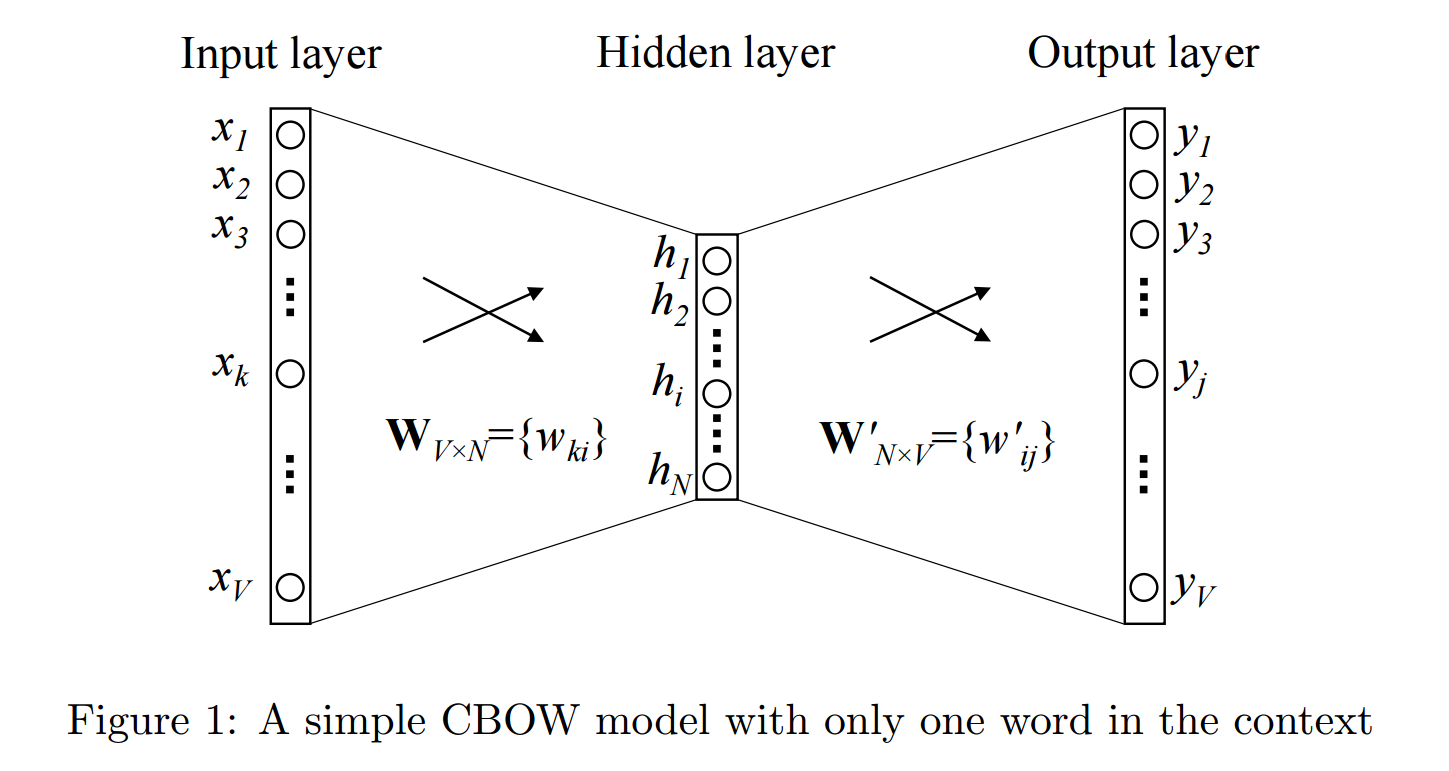
Source : https://lilianweng.github.io/posts/2017-10-15-word-embedding/
This is Word2Vec model where we first take the one-hot encoding of input word to W_embed and then to W_out to get the output probabilities 

In [7]:
!pip install -qU gensim

In [8]:
from gensim.models.word2vec import Word2Vec

In [14]:
text

['This',
 'is',
 'my',
 'new',
 'text',
 'for',
 'trying',
 'out',
 'the',
 'skip',
 'gram',
 'model']

In [10]:
model = Word2Vec(text,sg=1, vector_size=10, window=2, min_count=0, workers=4)
model.wv.save_word2vec_format("got_word2vec.txt", binary=False)

In [11]:
print(model.wv.vectors.shape)

(21, 10)


We can see that this is the same as W_embed. The sg=1 ensures that the skip-gram is chosen, window indicates the context size. hs=1 can be used to have Hierarchical softmax.

In [12]:
model.train([text], total_examples=model.corpus_count, epochs=10)

(0, 120)

In [13]:
print(model.wv[0])

[-0.00536218  0.00238271  0.05105656  0.09011675 -0.09304549 -0.07116832
  0.06461874  0.08972701 -0.05017912 -0.03760906]


Now we can use DeepWalks to generate node representation. It can be thought as like this, the random walk can produce a sequence of nodes that can act like a sentence. If two nodes appear together many times in the line, they are close. Now let us implement it.

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [16]:
random.seed(42) # for reproducability

In [19]:
G = nx.erdos_renyi_graph(20, 0.5, seed=42, directed=False)

This is a special type of graph generator. There are more available in network library.

In [21]:
def random_walk(start,length):
    walk =[start]
    for i in range(length):
        next_nodes = [node for node in G.neighbors(start)] 
        next_node = np.random.choice(next_nodes,42)[1]
        walk.append(next_node)
        start = next_node
    return walk

In [22]:
print(random_walk(0,6))

[0, 14, 9, 15, 19, 4, 13]


Now let us use it to solve it for a special type of graph (karate club)

In [24]:
G = nx.karate_club_graph()

In [32]:
G.nodes[20]

{'club': 'Officer'}

In [34]:
labels=[]
for i in G.nodes:
    label = G.nodes[i]['club']
    labels.append(1 if label=='Officer' else 0)

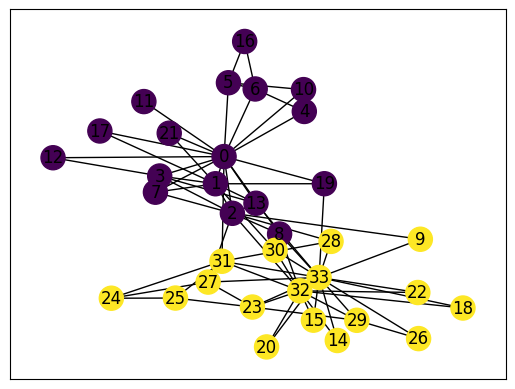

In [37]:
nx.draw_networkx(G,pos=nx.spring_layout(G, seed=0),node_color=labels)

Now let us do random walk on each of the nodes to get each sequence and then we will use it on Word2vec for representation learning.

In [38]:
all_walks=[]
for node in G.nodes:
    for l in range(80):
        all_walks.append(random_walk(node,10))

In [39]:
print(all_walks[9])

[0, 19, 33, 19, 33, 8, 0, 17, 0, 7, 1]


In [40]:
model = Word2Vec(all_walks,sg=1,hs=1,vector_size=100, window=2, min_count=0, workers=4)
model.train(all_walks, total_examples=model.corpus_count, epochs=10)

(62038, 299200)

In [45]:
model.wv.most_similar(0, topn=10)

[(10, 0.7158820629119873),
 (4, 0.6970500349998474),
 (6, 0.6803408265113831),
 (21, 0.6794175505638123),
 (5, 0.6667923927307129),
 (1, 0.6588327884674072),
 (7, 0.6587831377983093),
 (12, 0.6544221043586731),
 (11, 0.6275062561035156),
 (16, 0.614528238773346)]

In [46]:
model.wv.similarity(0,9)

0.18240878

In [48]:
model.wv.similarity(0,19)

0.47132877

Now let us do a TSNE plot of the embeddings to get a feel

In [49]:
from sklearn.manifold import TSNE

In [50]:
node_vector = np.array([model.wv.get_vector(i) for i in G.nodes])
labels= np.array(labels)

In [52]:
tsne = TSNE(n_components=2,learning_rate='auto',init='pca',random_state=0).fit_transform(node_vector)

In [53]:
tsne

array([[20.60671  , -6.3902373],
       [21.032307 , -6.160097 ],
       [21.348518 , -6.3010387],
       [20.925138 , -6.1294737],
       [20.203802 , -6.587129 ],
       [20.13604  , -6.6338396],
       [20.153622 , -6.6270394],
       [20.954065 , -6.311415 ],
       [21.504494 , -6.5546465],
       [21.487715 , -6.668403 ],
       [20.184544 , -6.5471206],
       [20.674223 , -6.456552 ],
       [20.72043  , -6.238137 ],
       [21.105585 , -6.4505844],
       [21.718405 , -6.9791665],
       [21.772781 , -6.9574866],
       [20.036114 , -6.6559052],
       [20.898329 , -6.275382 ],
       [21.797789 , -6.9100103],
       [21.056164 , -6.489081 ],
       [21.722961 , -6.9231296],
       [20.828045 , -6.344604 ],
       [21.823524 , -6.8749123],
       [21.698261 , -7.4236755],
       [21.252756 , -7.606799 ],
       [21.342785 , -7.6498485],
       [22.015043 , -7.1623344],
       [21.29121  , -7.3914022],
       [21.24836  , -7.107526 ],
       [21.933857 , -7.2600875],
       [21

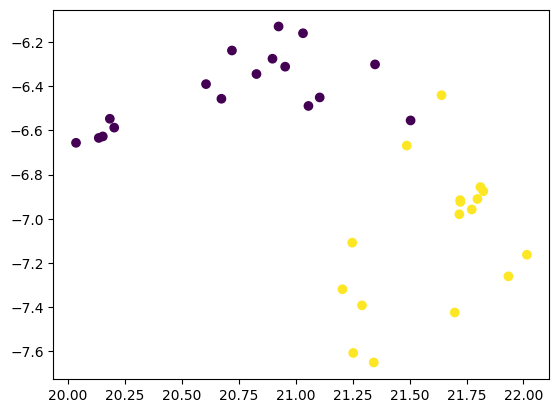

In [56]:
plt.scatter(tsne[:,0],tsne[:,1],c=labels)
plt.show()

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [58]:
train_mask = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
test_mask = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33]

In [59]:
clf = LogisticRegression(random_state=0).fit(node_vector[train_mask], labels[train_mask])

In [61]:
y_pred = clf.predict(node_vector[test_mask])
accuracy_score(y_pred, labels[test_mask])

0.9473684210526315

Wow 😲. This looks very good. The idea of using random walks as sentence to Word2vec did give good representation for nodes. This is very interesting. Now thats all for this section. Bye!!